## Предисловие ##
В коде сначала обучается variational autoencoder, чтобы затем использовать часть с декодером для генерации изображений в обучении с дискриминатором.

В других версиях кода пробовала использовать только модель generator+discriminator, сохраняла картинки, сгенерированные на каждой эпохе. Получалось плохо, модель стремилась к генерации одного и того же изображения для любых входных данных. Возможно, причина в том, что покемоны сильно отличаются по цвету, форме, по расположению глаз (мало характерных черт).
Поэтому решила использовать VAE для предобучения генератора.

Основная причина, почему не получилось - не хватило вычислительных мощностей для обучения. В google colab заканчивались ресурсы после двух запусков кода. Для вычислений на ноутбуке модель слишком большая. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout, Rescaling, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU
import zipfile

## Подготовка изображений ##
- лучше загружать zip-файл с датасетом и извлекать в самом коде (так быстрее)

!!! change data_dir при необходимости


In [ ]:
img_height = 128
img_width = 128

# папка в которой лежит заархивированный датасет
data_dir = "/content/drive/MyDrive/archive.zip"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = zipfile.ZipFile(data_dir, 'r')
data.extractall()

print(data)

<zipfile.ZipFile filename='/content/drive/MyDrive/archive.zip' mode='r'>


In [ ]:
import os
from PIL import Image
from matplotlib import image

def load_images(img_size):
    dirs = os.listdir('images')
    filecnt = 0
    dircnt = 0
    images = []
    labels = []
    for dir in dirs:
        files = os.listdir('images/'+dir)
        for filename in files:
            pil_image = Image.open('images/'+dir+'/'+filename)
            images.append(image.pil_to_array(pil_image.resize((img_size, img_size))))
            labels.append(dir)
            filecnt += 1
        dircnt += 1
    print('Найдено ', filecnt, ' файлов в ', dircnt, ' папках')
    return images, labels

images, labels = load_images(128)

Найдено  2503  файлов в  898  папках


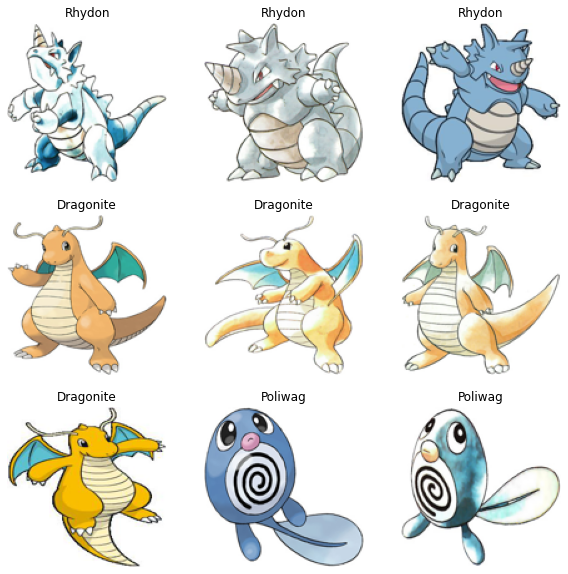

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[100+i])
    plt.title(labels[100+i])
    plt.axis("off")

In [ ]:
img_size = 128
batch_size = 500
x_train = np.array(images) / 255
x_train = np.reshape(x_train, (len(x_train), img_size, img_size, 3))

length = x_train.shape[0] // batch_size * batch_size
x_train = x_train[:length]
print(x_train.shape)

(2500, 128, 128, 3)


## Модель 1. Variational autoencoder. ##
- Предобучаем decoder, который затем станет генератором изображений. Это необходимо, чтобы потом генератор быстрее обучился с подходящими начальными весами. 
- VAE хорошо подходит, т.к. он учится генерировать картинки по вектору hidden_state с примерно нормальным распределением => будем знать, какие векторы подавать генератору

In [ ]:
hidden_dim = 128

def dropout_and_batch(x):
  return Dropout(0.3)(BatchNormalization()(x))

input_enc = Input((img_size, img_size, 3))
x = Flatten()(input_enc)
x = Dense(1024, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(512, activation='relu')(x)
x = dropout_and_batch(x)

h_mean = Dense(hidden_dim)(x)
log_hstd = Dense(hidden_dim)(x)

def make_hidden_state(harr):
    global h_mean, log_hstd
    h_mean, log_hstd = harr
    N = K.random_normal(shape=(hidden_dim,), mean=0., stddev=1.0)
    return K.exp(log_hstd / 2) * N + h_mean

hidden_state = Lambda(make_hidden_state, 
                      output_shape=(hidden_dim,))([h_mean, log_hstd])

input_dec = Input(shape=(hidden_dim,))
d = Dense(32*32*300, activation='relu')(input_dec)
d = BatchNormalization()(d)
d = Reshape((32, 32, 300))(d)
d = Conv2DTranspose(150, (5, 5), strides=(1, 1), padding='same', activation='relu')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(75, (5, 5), strides=(2, 2), padding='same', activation='relu')(d)
d = BatchNormalization()(d)
decoded = Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(d)

encoder = keras.Model(input_enc, hidden_state, name='encoder')
decoder = keras.Model(input_dec, decoded, name='decoder')

In [ ]:
def vae_loss(x, y):
    x = K.reshape(x, shape=(batch_size, img_size*img_size*3))
    y = K.reshape(y, shape=(batch_size, img_size*img_size*3))
    # отклонение сгенерированной картинки от настоящей
    loss = K.sum(K.square(x-y), axis=-1)
    # дивергенция Кульбака-Лейблера
    kl_loss = -0.5 * K.sum(1 + log_hstd - K.square(h_mean) - K.exp(log_hstd), axis=-1)
    return loss + kl_loss

vae = keras.Model(input_enc, decoder(encoder(input_enc)), name="vae")
vae.optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
vae.compile(loss=vae_loss)

num_epochs = 100
vae.fit(x_train[0:2500], x_train[0:2500],
        epochs=num_epochs, 
        batch_size=batch_size, 
        shuffle=True)


Epoch 1/100
5/5 [==============================] - 26s 955ms/step - loss: 10914.5381
Epoch 2/100
5/5 [==============================] - 5s 926ms/step - loss: 50983.7773
Epoch 3/100
5/5 [==============================] - 5s 939ms/step - loss: 7529.7598
Epoch 4/100
5/5 [==============================] - 5s 929ms/step - loss: 4898.1616
Epoch 5/100
5/5 [==============================] - 5s 947ms/step - loss: 5617.5234
Epoch 6/100
5/5 [==============================] - 5s 928ms/step - loss: 4291.5996
Epoch 7/100
5/5 [==============================] - 5s 942ms/step - loss: 19957.2480
Epoch 8/100
5/5 [==============================] - 5s 940ms/step - loss: 4305.2607
Epoch 9/100
5/5 [==============================] - 5s 949ms/step - loss: 4784.9219
Epoch 10/100
5/5 [==============================] - 5s 952ms/step - loss: 3936.9231
Epoch 11/100
5/5 [==============================] - 5s 945ms/step - loss: 4043.1509
Epoch 12/100
5/5 [==============================] - 5s 953ms/step - loss: 3777.63

Отображение полученных результатов:

1/1 [==============================] - 0s 16ms/step


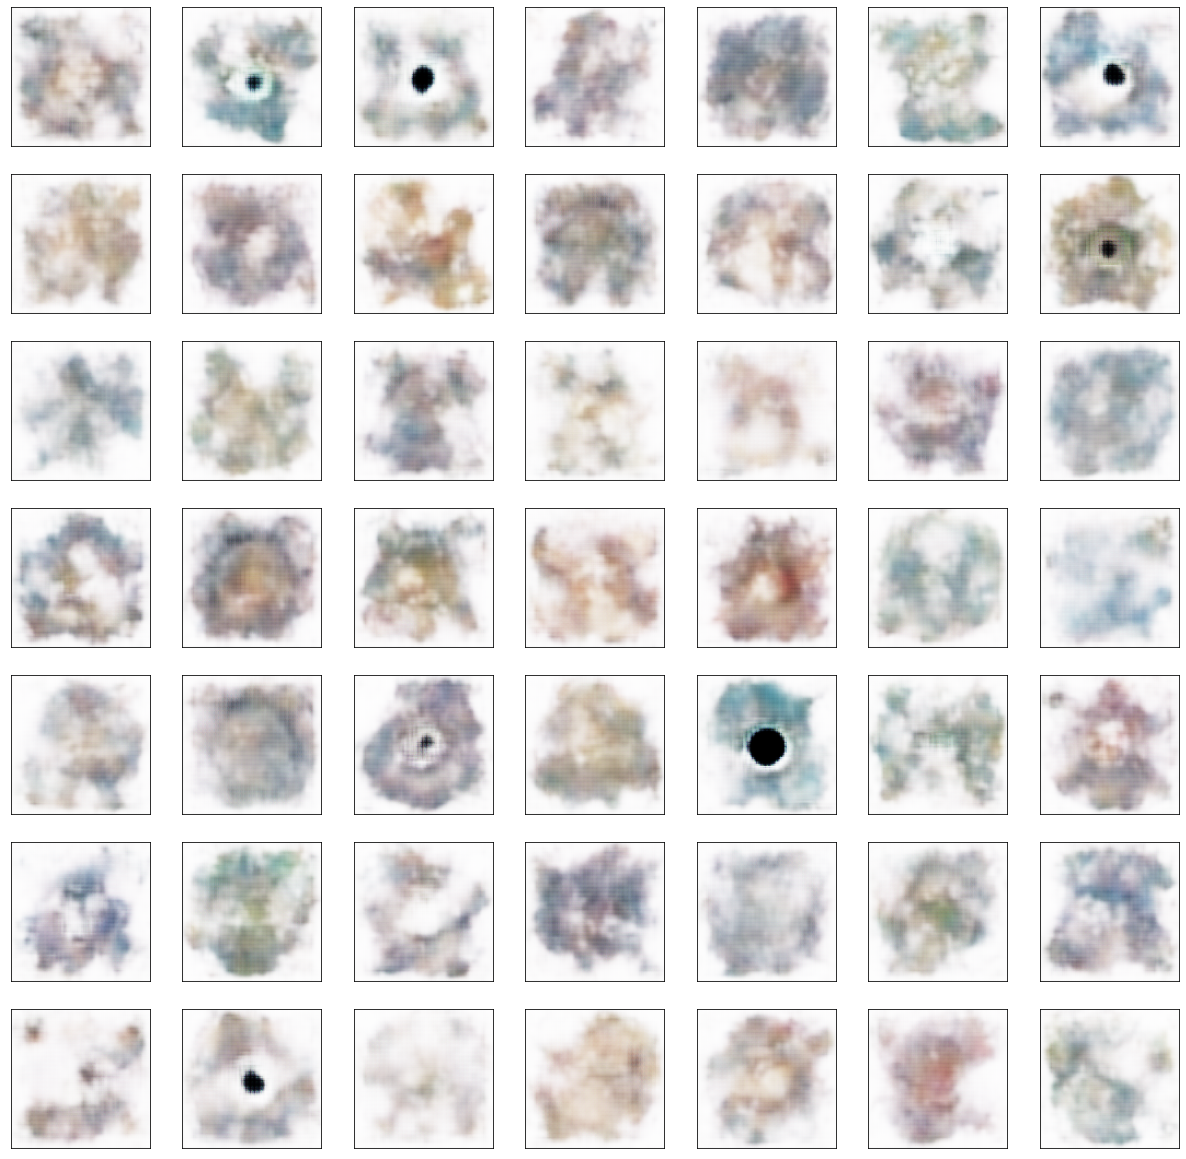

In [ ]:
n = 3
total = 2*n+1

plt.figure(figsize=(3*total, 3*total))

num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    h0 = tf.random.normal([1, hidden_dim])
    # img = np.array(decoder.predict(h0) * 255, dtype=int)
    img = np.array(decoder.predict(h0))
    plt.imshow(img.squeeze())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

decoder.save('/content/drive/MyDrive/dec1')

Вывод: есть какие-то образы, но смазанные + проблема с черными пятнами

## Модель 2. generator+discriminator. ##

In [ ]:
decoder = tf.keras.models.load_model("/content/drive/MyDrive/dec1")

discriminator = tf.keras.Sequential()

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=(img_size, img_size, 3,)))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1))

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
decoder_optimizer = tf.keras.optimizers.Adam(1e-4)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss


In [ ]:
# обучение
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, hidden_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = decoder(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, decoder.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  decoder_optimizer.apply_gradients(zip(gradients_of_generator, decoder.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss


import time
def train(dataset, epochs):
  history = []
  for epoch in range(1, epochs + 1):
    print(f'{epoch}/{EPOCHS}: ', end='')
    start = time.time()
    n = 0
    gen_loss_epoch = 0
    
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += K.mean(gen_loss)
      n += 1

    history += [gen_loss_epoch / n]
    print(': {:.5f}, за {:.2f} секунд'.format(history[-1], time.time() - start))

  return history


# запуск процесса обучения
EPOCHS = 10
batch_size = 100
dataset = tf.data.Dataset.from_tensor_slices(x_train[0:2500]).shuffle(2500).batch(batch_size)
history = train(dataset, EPOCHS)

1/10: : 0.72586, за 1042.25 секунд
2/10: : 0.74647, за 1017.57 секунд
3/10: : 0.73544, за 1105.23 секунд
4/10: 

KeyboardInterrupt: ignored

Отображение полученных результатов:

1/1 [==============================] - 0s 101ms/step


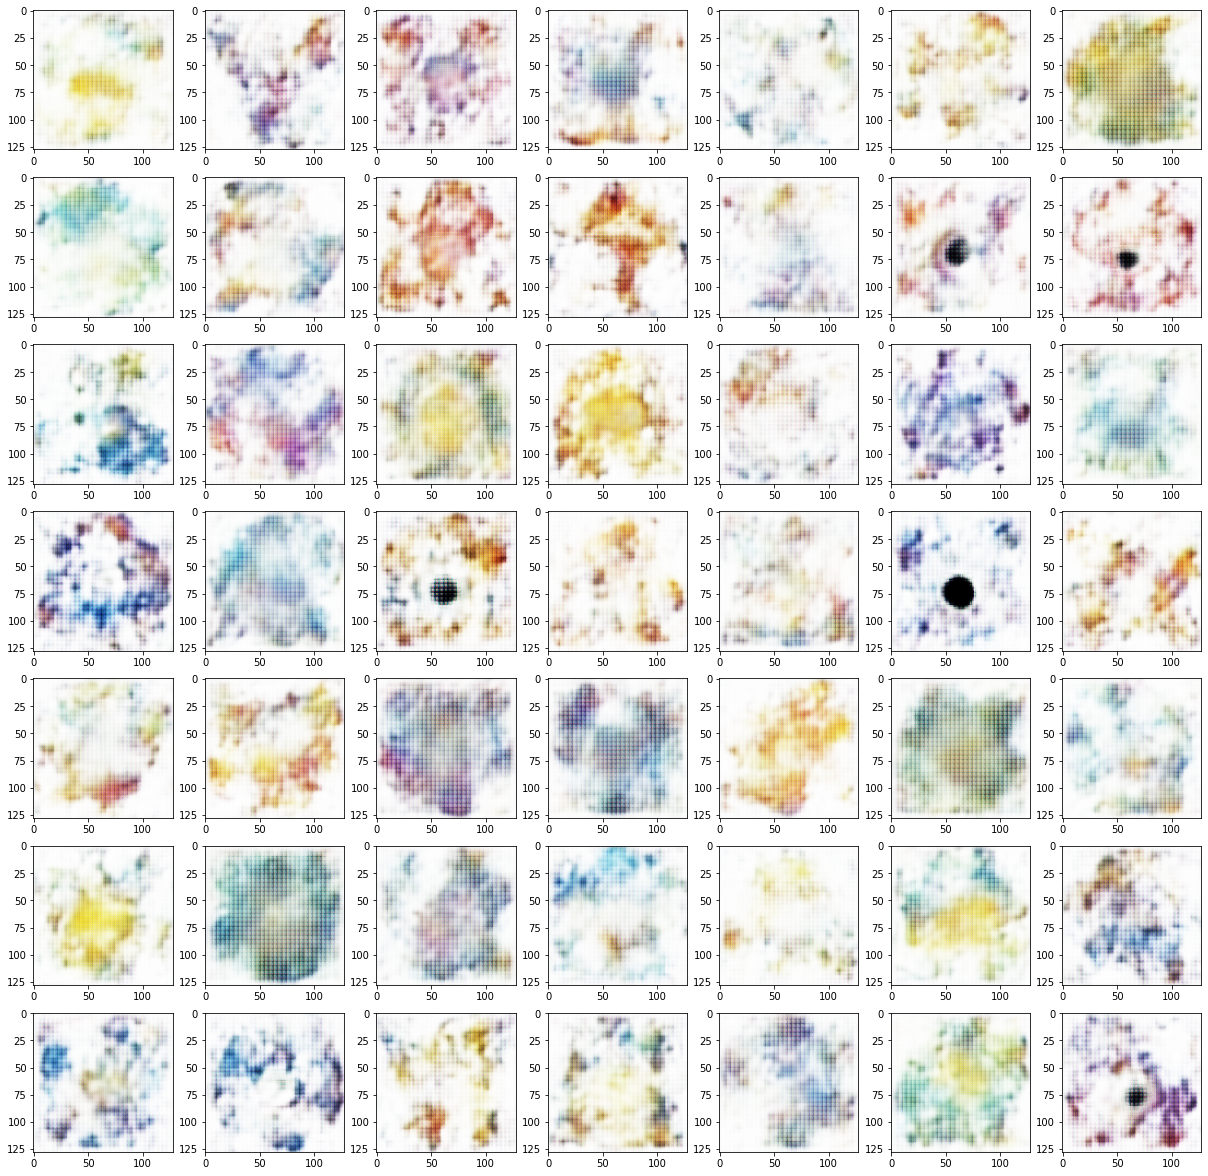

In [ ]:
decoder.save('/content/drive/MyDrive/gen2')
discriminator.save('/content/drive/MyDrive/disc2')

# отображение результатов генерации
n = 3
total = 2*n+1

plt.figure(figsize=(3*total, 3*total))

num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    h0 = tf.random.normal([1, hidden_dim])
    #img = np.array(decoder.predict(h0) * 255, dtype=int)
    img = np.array(decoder.predict(h0))
    plt.imshow(img.squeeze())

plt.show()


Вывод: стало хуже, при большем количестве эпох стремится к статичной картинке для любого hidden_state